In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate=dt.datetime.strptime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0],'%Y-%m-%d')
query_date=lastdate-dt.timedelta(days=365)
lastdate
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
results_df=pd.DataFrame(results,columns=['Date','Precipitation']).set_index('Date')

# Sort the dataframe by date
results_df.sort_index(ascending=True, inplace=True)
results_df.head()




,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


Text(0.5,1,'Precipitation in Hawaii from 8-23-2016 to 8-23-2017')

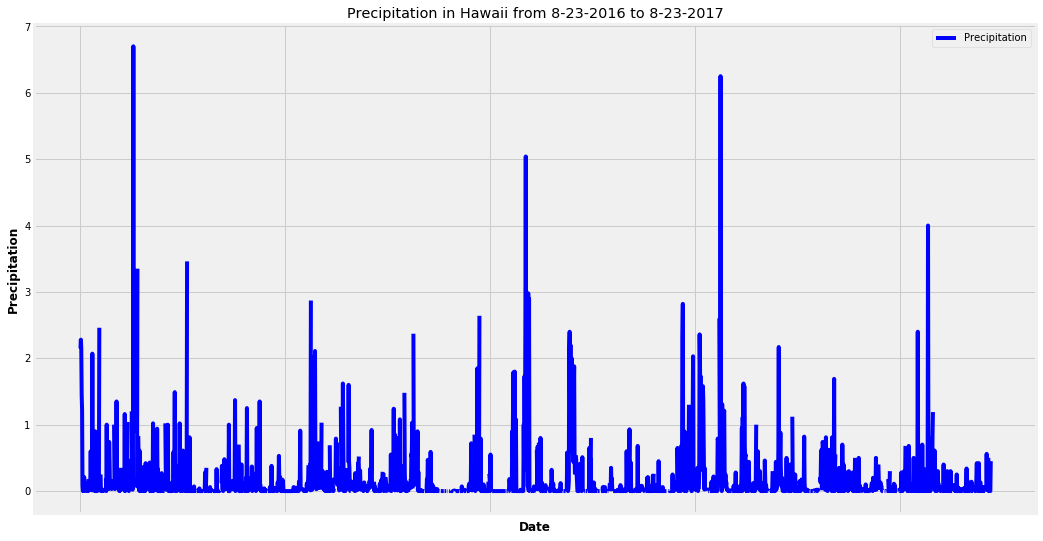

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
prec_plot = results_df.plot(figsize = (16, 9), sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='b')
plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii from 8-23-2016 to 8-23-2017")


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
print(session.query(Measurement.station).\
                   group_by(Measurement.station).count())

9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()


In [26]:
most_active_station

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station==most_active_station[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mosttempobs=session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()[0][0]

results_temp=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station==mosttempobs).\
    filter(Measurement.date > query_date).all()

In [29]:
mosttempobs

'USC00519281'

In [31]:
temperature_df=pd.DataFrame(results_temp)
temperature_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


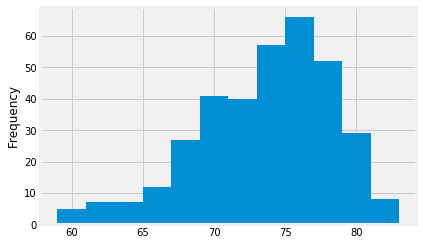

In [32]:
plt.hist(temperature_df['tobs'], bins=12)
plt.ylabel('Frequency')
plt.savefig('Images/chane_station_analysis.png')
plt.show()

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_current='2018-02-20'
end_current='2018-02-26'

start=dt.datetime.strptime(start_current,'%Y-%m-%d')-dt.timedelta(days=365)
end=dt.datetime.strptime(end_current,'%Y-%m-%d')-dt.timedelta(days=365)

print(calc_temps(start, end))

[(61.0, 69.29729729729729, 75.0)]


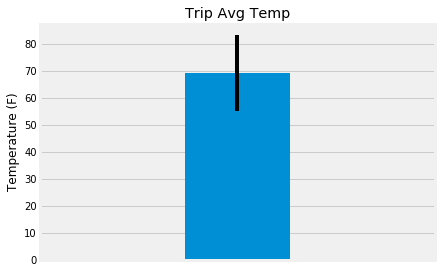

In [36]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
ax.bar(x=0,height=calc_temps(start, end)[0][1],yerr=calc_temps(start, end)[0][2]-calc_temps(start, end)[0][0])
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
plt.tight_layout()
ax.set_xlim(-1.5,1.5)
plt.xticks([])
plt.ylabel('Temperature (F)')
plt.savefig('Images/chane_temperature_analysis.png')
plt.show()

In [37]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


print(session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station==Station.station).\
    filter(Measurement.date >= start).\
    filter(Measurement.date <= end).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all())

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.51), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.17), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.13), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.11), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06)]


## Optional Challenge Assignment

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
